
# Credit Risk Assessment — Give Me Some Credit (CSV)
**Goal:** Assess client default risk (binary classification) using financial-history features.  
**Data:** `cs-training.csv` (labeled), `cs-test.csv` (unlabeled), `sampleEntry.csv` (submission template).  
**Target:** `SeriousDlqin2yrs` (1 = default within 2 years).

## What this notebook does
1. Load & sanity-check data; handle missingness and outliers
2. Build a clean preprocessing + model pipeline (impute → clip → scale → model)
3. Train baselines and a stronger model; use **precision**, **recall**, and **ROC-AUC** for evaluation
4. Optional threshold tuning (maximize F1) and business-style metrics table
5. Fit on full training set and generate predictions for `cs-test.csv` (submission-ready)
6. Save trained model and artifacts


In [ ]:

# --- Imports & configuration ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, precision_score, recall_score, roc_auc_score,
                             roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_PATH = "cs-training.csv"
TEST_PATH  = "cs-test.csv"




## 1) Load Data
The Kaggle **Give Me Some Credit** dataset typically includes an ID column (often `Unnamed: 0`) and ten numeric predictors. We’ll drop the ID from features and keep it for submissions.


In [15]:

# --- Load CSVs ---
assert os.path.exists(TRAIN_PATH), f"Missing file: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing file: {TEST_PATH}"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("Train columns:", train_df.columns.tolist())
print("Test  columns:", test_df.columns.tolist())

# Identify ID column (commonly 'Unnamed: 0')
id_col = None
for cand in ["Id", "id", "ID", "Unnamed: 0"]:
    if cand in train_df.columns:
        id_col = cand
        break

if id_col is None:
    train_df["GenID"] = np.arange(len(train_df))
    test_df["GenID"]  = np.arange(len(test_df))
    id_col = "GenID"

print("Using ID column:", id_col)

target_col = "SeriousDlqin2yrs"
assert target_col in train_df.columns, f"Target column '{target_col}' not found in training data."

y = train_df[target_col].astype(int).values
X = train_df.drop(columns=[target_col]).copy()

test_ids = test_df[id_col].copy()
X_test_full = test_df.copy()

X.drop(columns=[id_col], inplace=True, errors="ignore")
X_test_full.drop(columns=[id_col], inplace=True, errors="ignore")

print("Feature columns:", X.columns.tolist())


Train shape: (150000, 12)
Test shape : (101503, 12)
Train columns: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Test  columns: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Using ID column: Unnamed: 0
Feature columns: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'Numb


## 2) Quick EDA & Sanity Checks
- Missingness overview
- Basic descriptive stats
- Class balance


In [16]:

missing_train = X.isna().sum().sort_values(ascending=False)
print("Top missing (train):\n", missing_train.head(10))

display_cols = X.columns[:6].tolist()
print("\nDescriptive stats (first 6 features):")
print(X[display_cols].describe())

unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution (0 = no default, 1 = default):", dict(zip(unique, counts)))
print("Default rate: %.2f%%" % (100 * counts[1]/counts.sum()))


Top missing (train):
 MonthlyIncome                           29731
NumberOfDependents                       3924
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
dtype: int64

Descriptive stats (first 6 features):
       RevolvingUtilizationOfUnsecuredLines            age  \
count                         150000.000000  150000.000000   
mean                               6.048438      52.295207   
std                              249.755371      14.771866   
min                                0.000000       0.000000   
25%                                0.029867      41.000000   
50%                                0.154181      52.000000   
75%                             


## 3) Preprocessing Plan
- **Impute** missing numeric values with **median** and add missing indicators.  
- **Clip outliers** using per-feature 1st/99th percentile (computed on training split).  
- **Scale** features with `StandardScaler` for linear models.


In [17]:

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, q_low=0.01, q_high=0.99):
        self.q_low = q_low
        self.q_high = q_high
        self.lower_ = None
        self.upper_ = None
        self.columns_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
            q = X.quantile([self.q_low, self.q_high])
            self.lower_ = q.loc[self.q_low].values
            self.upper_ = q.loc[self.q_high].values
        else:
            X_df = pd.DataFrame(X)
            q = X_df.quantile([self.q_low, self.q_high])
            self.lower_ = q.loc[self.q_low].values
            self.upper_ = q.loc[self.q_high].values
            self.columns_ = None
        return self

    def transform(self, X):
        X_arr = X.values if isinstance(X, pd.DataFrame) else X
        clipped = np.minimum(np.maximum(X_arr, self.lower_), self.upper_)
        if self.columns_ is not None:
            return pd.DataFrame(clipped, columns=self.columns_)
        return clipped

num_features = X.columns.tolist()
num_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("clipper", QuantileClipper(q_low=0.01, q_high=0.99)),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transform, num_features)
])



## 4) Train/Validation Split


In [18]:

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)
print("Default rate — train: %.2f%%, val: %.2f%%" % (
    100 * y_train.mean(), 100 * y_val.mean()
))


Train shape: (120000, 10) Val shape: (30000, 10)
Default rate — train: 6.68%, val: 6.68%



## 5) Models & Evaluation (Precision, Recall, ROC-AUC)



=== LogReg_balanced ===
Precision: 0.2200  |  Recall: 0.7496  |  ROC-AUC: 0.8614

Classification report:
              precision    recall  f1-score   support

           0     0.9783    0.8096    0.8860     27995
           1     0.2200    0.7496    0.3401      2005

    accuracy                         0.8056     30000
   macro avg     0.5991    0.7796    0.6131     30000
weighted avg     0.9276    0.8056    0.8495     30000



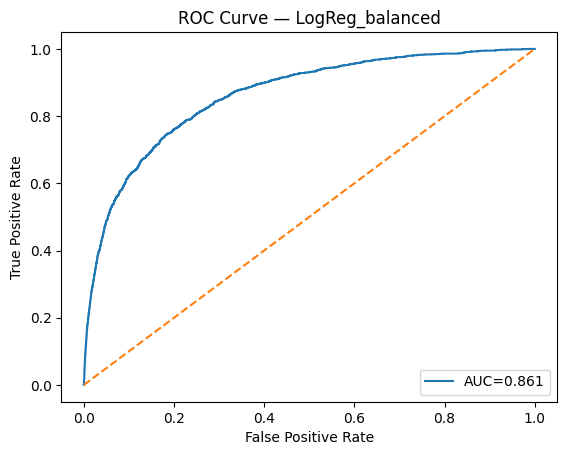


=== GradBoost ===
Precision: 0.6024  |  Recall: 0.2025  |  ROC-AUC: 0.8682

Classification report:
              precision    recall  f1-score   support

           0     0.9455    0.9904    0.9674     27995
           1     0.6024    0.2025    0.3031      2005

    accuracy                         0.9378     30000
   macro avg     0.7739    0.5965    0.6353     30000
weighted avg     0.9225    0.9378    0.9230     30000



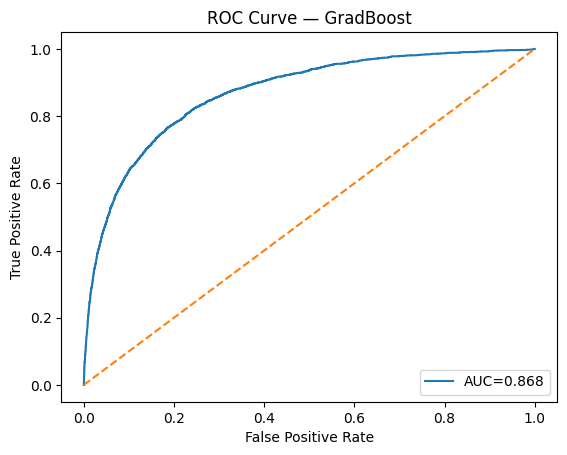


=== RandomForest ===
Precision: 0.5645  |  Recall: 0.1791  |  ROC-AUC: 0.8490

Classification report:
              precision    recall  f1-score   support

           0     0.9439    0.9901    0.9665     27995
           1     0.5645    0.1791    0.2719      2005

    accuracy                         0.9359     30000
   macro avg     0.7542    0.5846    0.6192     30000
weighted avg     0.9186    0.9359    0.9201     30000



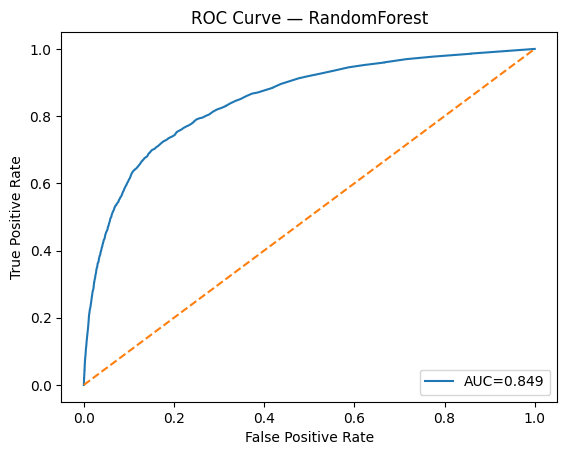


Summary (sorted by ROC-AUC):
             model  precision    recall   roc_auc
1        GradBoost   0.602374  0.202494  0.868150
0  LogReg_balanced   0.219962  0.749626  0.861367
2     RandomForest   0.564465  0.179052  0.849004


In [19]:

from collections import OrderedDict
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

candidates = OrderedDict({
    "LogReg_balanced": Pipeline([
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
    ]),
    "GradBoost": Pipeline([
        ("prep", preprocessor),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=500, random_state=42))
    ]),
})

def evaluate_model(pipe, X_tr, y_tr, X_va, y_va, name="model"):
    pipe.fit(X_tr, y_tr)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_va)[:, 1]
    elif hasattr(pipe, "decision_function"):
        scores = pipe.decision_function(X_va)
        ranks = pd.Series(scores).rank().values
        y_proba = ranks / ranks.max()
    else:
        y_proba = pipe.predict(X_va).astype(float)

    y_pred = (y_proba >= 0.5).astype(int)

    prec = precision_score(y_va, y_pred, zero_division=0)
    rec  = recall_score(y_va, y_pred, zero_division=0)
    auc  = roc_auc_score(y_va, y_proba)

    print(f"\n=== {name} ===")
    print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}  |  ROC-AUC: {auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_va, y_pred, digits=4))

    fpr, tpr, _ = roc_curve(y_va, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"ROC Curve — {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    return {"model": name, "precision": prec, "recall": rec, "roc_auc": auc}, pipe

results = []
fitted = {}
for name, pipe in candidates.items():
    res, trained = evaluate_model(pipe, X_train, y_train, X_val, y_val, name=name)
    results.append(res)
    fitted[name] = trained

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
print("\nSummary (sorted by ROC-AUC):")
print(results_df)



## 6) Threshold Tuning (Optional): Max F1


Best by ROC-AUC: GradBoost
Best threshold by F1: 0.20  |  F1=0.4456  |  Precision=0.4008  |  Recall=0.5017


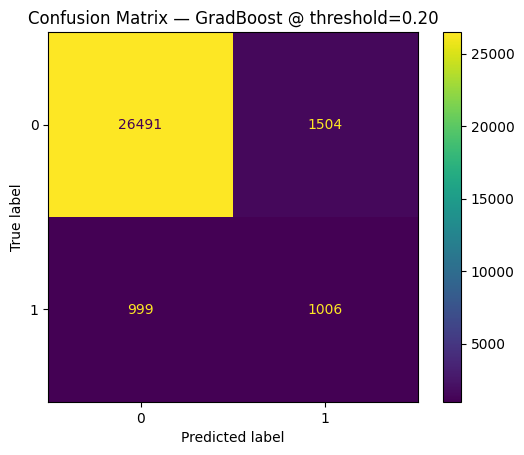

In [20]:

best_name = results_df.iloc[0]["model"]
best_model = fitted[best_name]
print("Best by ROC-AUC:", best_name)

if hasattr(best_model, "predict_proba"):
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
elif hasattr(best_model, "decision_function"):
    scores = best_model.decision_function(X_val)
    ranks = pd.Series(scores).rank().values
    y_val_proba = ranks / ranks.max()
else:
    y_val_proba = best_model.predict(X_val).astype(float)

ths = np.linspace(0.05, 0.95, 19)
best_f1 = -1
best_thr = 0.5
best_prec = 0
best_rec = 0

for t in ths:
    preds = (y_val_proba >= t).astype(int)
    p = precision_score(y_val, preds, zero_division=0)
    r = recall_score(y_val, preds, zero_division=0)
    f1 = 0 if (p + r) == 0 else 2*p*r/(p+r)
    if f1 > best_f1:
        best_f1, best_thr, best_prec, best_rec = f1, t, p, r

print(f"Best threshold by F1: {best_thr:.2f}  |  F1={best_f1:.4f}  |  Precision={best_prec:.4f}  |  Recall={best_rec:.4f}")

cm = confusion_matrix(y_val, (y_val_proba >= best_thr).astype(int), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title(f"Confusion Matrix — {best_name} @ threshold={best_thr:.2f}")
plt.show()



## 7) Train Final Model & Generate Submission


In [ ]:
final_model = fitted[best_name]
final_model.fit(X, y)

if hasattr(final_model, "predict_proba"):
    test_proba = final_model.predict_proba(X_test_full)[:, 1]
elif hasattr(final_model, "decision_function"):
    scores = final_model.decision_function(X_test_full)
    ranks = pd.Series(scores).rank().values
    test_proba = ranks / ranks.max()
else:
    test_proba = final_model.predict(X_test_full).astype(float)


sub_cols = ("Id", "Probability")
if os.path.exists(SUB_SAMPLE):
    sample = pd.read_csv(SUB_SAMPLE)
    if set(sub_cols).issubset(sample.columns):
        id_col_in_sample = "Id"
        sub = pd.DataFrame({"Id": sample["Id"], "Probability": test_proba[:len(sample)]})
    else:
        sub = pd.DataFrame({"Id": np.arange(1, len(test_proba)+1), "Probability": test_proba})
else:
    sub = pd.DataFrame({"Id": np.arange(1, len(test_proba)+1), "Probability": test_proba})

EXPORT_DIR = "/Users/jivalpatel/Downloads/Volunteer Work/Credit Risk Assesment"
os.makedirs(EXPORT_DIR, exist_ok=True)
SUB_PATH = os.path.join(EXPORT_DIR, "credit_risk_submission.csv")
MODEL_PATH = os.path.join(EXPORT_DIR, f"credit_risk_{best_name}.joblib")

sub.to_csv(SUB_PATH, index=False)
import joblib
joblib.dump(final_model, MODEL_PATH)

print("Saved submission to:", SUB_PATH)
print("Saved model to:", MODEL_PATH)


Saved submission to: /Users/jivalpatel/Downloads/Volunteer Work/Credit Risk Assesment/credit_risk_submission.csv
Saved model to: /Users/jivalpatel/Downloads/Volunteer Work/Credit Risk Assesment/credit_risk_GradBoost.joblib



## 9) Precision–Recall Curve & PR-AUC (Imbalanced Evaluation)
We add **PR-AUC** (average precision) and the **precision–recall curve**. These are often more informative than ROC for rare-event risk.


PR-AUC (Average Precision): 0.4078


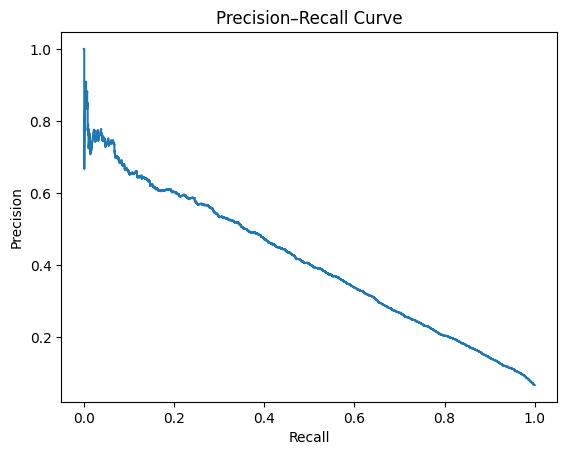

In [23]:

# Compute y_val_proba if not already present
try:
    y_val_proba  # noqa: F821
except NameError:
    # Fallback: grab the best model from earlier and compute probabilities
    if 'best_name' in globals() and 'fitted' in globals():
        best_model = fitted[best_name]
    else:
        # Last-resort: choose GradBoost if available
        best_key = None
        if 'fitted' in globals():
            for k in fitted:
                if 'GradBoost' in k:
                    best_key = k
                    break
            best_model = fitted[best_key] if best_key else None
        else:
            best_model = None
    if best_model is None:
        raise RuntimeError("Could not locate a trained model from earlier cells. Please run model training cells first.")
    if hasattr(best_model, 'predict_proba'):
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
    elif hasattr(best_model, 'decision_function'):
        scores = best_model.decision_function(X_val)
        ranks = pd.Series(scores).rank().values
        y_val_proba = ranks / ranks.max()
    else:
        y_val_proba = best_model.predict(X_val).astype(float)

from sklearn.metrics import average_precision_score, precision_recall_curve

ap = average_precision_score(y_val, y_val_proba)
print(f"PR-AUC (Average Precision): {ap:.4f}")

prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()



## 10) Cost-Based Threshold — Expected Cost Curve
Pick a decision threshold using **business costs**: set cost of **false negative (C_FN)** and **false positive (C_FP)** and minimize expected cost across thresholds.


Min expected cost threshold: 0.08 | Expected cost: 9836.00 (C_FN=10.0, C_FP=1.0)


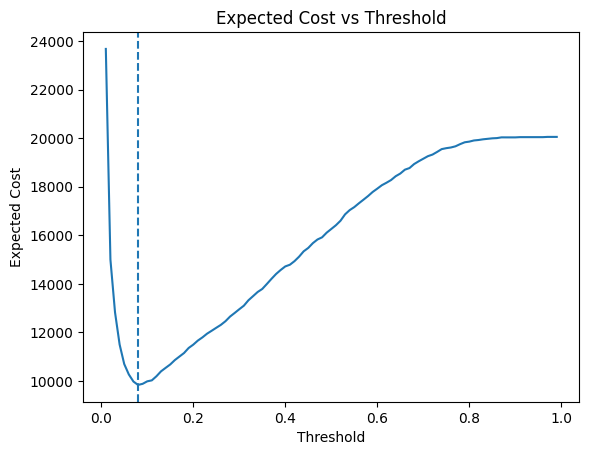

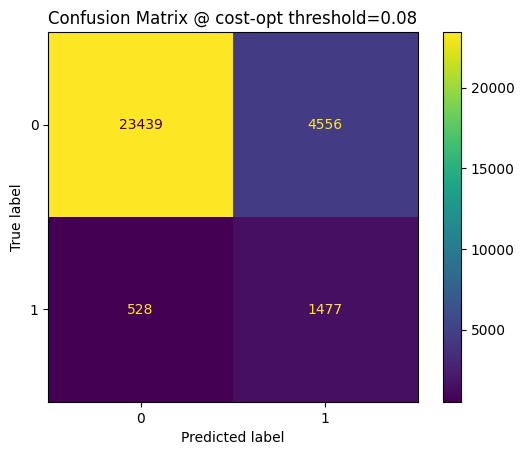

Precision @ cost-opt: 0.2448 | Recall @ cost-opt: 0.7367


In [24]:

# Define business costs here (edit for your scenario)
C_FN = 10.0   # cost of missing a defaulter (false negative)
C_FP = 1.0    # cost of flagging a non-defaulter (false positive)

import numpy as np
ths = np.linspace(0.01, 0.99, 99)

def expected_cost_at_threshold(y_true, y_scores, t, c_fn, c_fp):
    preds = (y_scores >= t).astype(int)
    # Confusion counts
    tn = np.sum((y_true == 0) & (preds == 0))
    fp = np.sum((y_true == 0) & (preds == 1))
    fn = np.sum((y_true == 1) & (preds == 0))
    tp = np.sum((y_true == 1) & (preds == 1))
    # Only false outcomes cost money in this simple formulation
    return c_fn * fn + c_fp * fp, (tn, fp, fn, tp)

costs = []
for t in ths:
    c, _ = expected_cost_at_threshold(y_val, y_val_proba, t, C_FN, C_FP)
    costs.append(c)

best_idx = int(np.argmin(costs))
best_thr_cost = ths[best_idx]
best_cost = costs[best_idx]
print(f"Min expected cost threshold: {best_thr_cost:.2f} | Expected cost: {best_cost:.2f} (C_FN={C_FN}, C_FP={C_FP})")

plt.figure()
plt.plot(ths, costs)
plt.axvline(best_thr_cost, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Expected Cost vs Threshold")
plt.show()

# Confusion matrix at cost-optimal threshold
_, (tn, fp, fn, tp) = expected_cost_at_threshold(y_val, y_val_proba, best_thr_cost, C_FN, C_FP)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score

cm = confusion_matrix(y_val, (y_val_proba >= best_thr_cost).astype(int), labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title(f"Confusion Matrix @ cost-opt threshold={best_thr_cost:.2f}")
plt.show()

p = precision_score(y_val, (y_val_proba >= best_thr_cost).astype(int), zero_division=0)
r = recall_score(y_val, (y_val_proba >= best_thr_cost).astype(int), zero_division=0)
print(f"Precision @ cost-opt: {p:.4f} | Recall @ cost-opt: {r:.4f}")



## 11) Decile Table (Lift/Gain), KS & Gini
Create a decile table by sorting by predicted probability. Report cumulative **capture** of defaults, **lift**, and compute **KS** & **Gini**.


In [30]:

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

df_eval = pd.DataFrame({"y": y_val, "score": y_val_proba}).sort_values("score", ascending=False).reset_index(drop=True)
n = len(df_eval)
base_rate = df_eval["y"].mean()
df_eval["decile"] = (np.floor(np.arange(n) / np.ceil(n/10))).astype(int) + 1
df_eval.loc[df_eval["decile"]>10, "decile"] = 10

dec = df_eval.groupby("decile").agg(
    total=("y", "count"),
    events=("y", "sum")
).reset_index()
dec["non_events"] = dec["total"] - dec["events"]
dec["event_rate"] = dec["events"] / dec["total"]

# Cumulative
dec["cum_events"] = dec["events"].cumsum()
dec["cum_non_events"] = dec["non_events"].cumsum()
dec["cum_events_perc"] = dec["cum_events"] / df_eval["y"].sum()
dec["cum_non_events_perc"] = dec["cum_non_events"] / (len(df_eval) - df_eval["y"].sum())

# Lift & Gain
dec["gain"] = dec["cum_events_perc"]
dec["lift"] = dec["event_rate"] / base_rate

# KS & Gini
dec["ks"] = np.abs(dec["cum_events_perc"] - dec["cum_non_events_perc"])
KS = dec["ks"].max()
AUC = roc_auc_score(df_eval["y"], df_eval["score"])
GINI = 2*AUC - 1

print(f"Baseline rate: {base_rate:.4f} | KS: {KS:.4f} | AUC: {AUC:.4f} | Gini: {GINI:.4f}")
dec


Baseline rate: 0.0668 | KS: 0.5735 | AUC: 0.8682 | Gini: 0.7363


,decile,total,events,non_events,event_rate,cum_events,cum_non_events,cum_events_perc,cum_non_events_perc,gain,lift,ks
0,1,3000,1107,1893,0.369000,1107,1893,0.552120,0.067619,0.552120,5.521197,0.484500
1,2,3000,367,2633,0.122333,1474,4526,0.735162,0.161672,0.735162,1.830424,0.573490
2,3,3000,200,2800,0.066667,1674,7326,0.834913,0.261690,0.834913,0.997506,0.573223
3,4,3000,113,2887,0.037667,1787,10213,0.891272,0.364815,0.891272,0.563591,0.526457
4,5,3000,72,2928,0.024000,1859,13141,0.927182,0.469405,0.927182,0.359102,0.457777
5,6,3000,59,2941,0.019667,1918,16082,0.956608,0.574460,0.956608,0.294264,0.382149
6,7,3000,40,2960,0.013333,1958,19042,0.976559,0.680193,0.976559,0.199501,0.296366
7,8,3000,19,2981,0.006333,1977,22023,0.986035,0.786676,0.986035,0.094763,0.199359
8,9,3000,13,2987,0.004333,1990,25010,0.992519,0.893374,0.992519,0.064838,0.099145
9,10,3000,15,2985,0.005000,2005,27995,1.000000,1.000000,1.000000,0.074813,0.000000


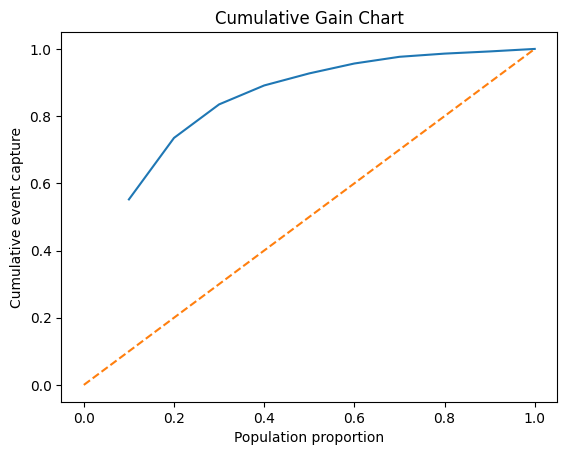

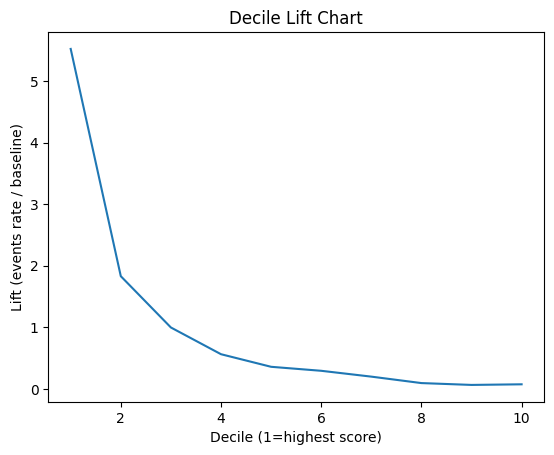

In [32]:

# Plot cumulative gain and decile lift (separate figures)
plt.figure()
plt.plot(dec["decile"]/10.0, dec["gain"])
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Population proportion")
plt.ylabel("Cumulative event capture")
plt.title("Cumulative Gain Chart")
plt.show()

plt.figure()
plt.plot(dec["decile"], dec["lift"])
plt.xlabel("Decile (1=highest score)")
plt.ylabel("Lift (events rate / baseline)")
plt.title("Decile Lift Chart")
plt.show()
